<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Example-data-on-2021-04-10" data-toc-modified-id="Example-data-on-2021-04-10-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Example data on 2021-04-10</a></span><ul class="toc-item"><li><span><a href="#Crowd-related-metrics" data-toc-modified-id="Crowd-related-metrics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Crowd-related metrics</a></span></li><li><span><a href="#Path-Efficiency-related-metrics" data-toc-modified-id="Path-Efficiency-related-metrics-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Path Efficiency-related metrics</a></span></li><li><span><a href="#Shared-control-related-metrics" data-toc-modified-id="Shared-control-related-metrics-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Shared control-related metrics</a></span></li></ul></li><li><span><a href="#Archive" data-toc-modified-id="Archive-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Archive</a></span><ul class="toc-item"><li><span><a href="#Crowd" data-toc-modified-id="Crowd-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Crowd</a></span></li><li><span><a href="#Path-Efficiency" data-toc-modified-id="Path-Efficiency-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Path Efficiency</a></span></li><li><span><a href="#Shared-Control" data-toc-modified-id="Shared-Control-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Shared Control</a></span></li></ul></li></ul></div>

# Crowd navigation evaluation

> Analysis of different control methods on different datas

In [1]:
import math
import collections
import urllib.request
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns
sns.set_theme()

import sys, os, fnmatch
# Importing Metrics Functions:
# sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'src'))
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'qolo'))

from crowd_evaluation import *
from crowdbot_data import CrowdBotData, CrowdBotDatabase
from notebook_util import walk, boxplot

%matplotlib inline

In [2]:
qolo_dataset = CrowdBotData()

bagbase = qolo_dataset.bagbase_dir
outbase = qolo_dataset.outbase_dir

print("rosbag database:", bagbase)
print(os.listdir(bagbase))
print()
print("output database:", outbase)
print(os.listdir(outbase))

control_types = ['mds', 'rds', 'shared_control']

rosbag database: /hdd/data_qolo/crowd_qolo_recordings/
['0325_rds', '0410_mds', '0410_rds', '0410_shared_control', '0424_mds', '0424_rds', '0424_shared_control', 'MDS', 'RDS', 'readme.md', 'shared_control', 'shared_test', 'test']

output database: /hdd/data_qolo/crowdbot_data_analysis/
['0410_mds_processed', '0410_rds_processed', '0410_shared_control_processed', '0424_mds_processed', '0424_rds_processed', '0424_shared_control_processed', 'MDS_processed', 'shared_test_processed', 'test_processed']


In [3]:
#!sh data_export_pipeline.sh -e=py38cuda110 -t=shared_test

## Example data on 2021-04-10

In [4]:
example_date = '0424'
eval_dirs = []
for root, dirs, files in walk(bagbase, topdown=False, maxdepth=1):
    for dir in dirs:
        if (example_date in dir):
            eval_dirs.append(dir)
            print("{}/ is available!".format(dir))

0424_mds/ is available!
0424_rds/ is available!
0424_shared_control/ is available!


In [5]:
# for eval_dir in eval_dirs:
eval_dir = eval_dirs[0]
print("Reading results from {}".format(eval_dir))

# new a CrowdBotDatabase() instance
eval_database = CrowdBotDatabase(folder=eval_dir)

Reading results from 0424_mds


In [12]:
print("Available sequences in {}:\n{}".format(eval_dir, eval_database.seqs))

Available sequences in 0424_shared_control:
['2021-04-24-13-07-54', '2021-04-24-13-11-03', '2021-04-24-13-14-49', '2021-04-24-13-16-58', '2021-04-24-13-20-05', '2021-04-24-13-22-52', '2021-04-24-13-22-52-002', '2021-04-24-13-25-24-001', '2021-04-24-13-27-09-003']


### Crowd-related metrics

In [7]:
metrics = ('avg_crowd_density5', 'avg_crowd_density10', 'avg_min_dist')

# more_metrics = (
#     'crowd_density5',
#     'crowd_density10',
#     'min_dist',
# )

frames = []

for eval_dir in eval_dirs:

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(folder=eval_dir)

    m_dict = {'seq': eval_database.seqs}
    m_dict.update(
        {'control_type': [eval_dir[5:] for i in range(eval_database.nr_seqs())]}
    )
    m_dict.update({k: [] for k in metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        crowd_eval_npy = os.path.join(eval_res_dir, seq + "_crowd_eval.npy")
        crowd_eval_dict = np.load(
            crowd_eval_npy,
            allow_pickle=True,
        ).item()

        for iidx, val in enumerate(metrics):
            m_dict[metrics[iidx]].append(crowd_eval_dict[val])

    dir_df = pd.DataFrame(m_dict)
    dir_df.columns = ['seq', 'control_type'] + list(metrics)

    frames.append(dir_df)

crowd_metrics_df = pd.concat(frames)

# crowd__metrics_df.head()
print(crowd_metrics_df.to_string(index=False))


Reading results from 0424_mds
Reading results from 0424_rds
Reading results from 0424_shared_control
                    seq   control_type  avg_crowd_density5  avg_crowd_density10  avg_min_dist
    2021-04-24-12-04-04            mds            0.120290             0.061124      1.667078
    2021-04-24-12-07-57            mds            0.093233             0.046961      2.219815
    2021-04-24-12-10-45            mds            0.149362             0.069602      1.728294
    2021-04-24-12-54-04            mds            0.114009             0.062583      1.909025
    2021-04-24-12-56-59            mds            0.137841             0.068062      1.722945
    2021-04-24-13-03-39            mds            0.150969             0.061873      1.786513
    2021-04-24-11-20-18            rds            0.160733             0.070133      1.633202
    2021-04-24-11-23-43            rds            0.125135             0.063976      1.751423
    2021-04-24-11-35-54            rds            0.1

- choose specific control type

In [8]:
crowd_metrics_df[crowd_metrics_df.control_type == 'shared_control']

,seq,control_type,avg_crowd_density5,avg_crowd_density10,avg_min_dist
0,2021-04-24-13-07-54,shared_control,0.149252,0.069288,1.733505
1,2021-04-24-13-11-03,shared_control,0.140995,0.069307,1.766926
2,2021-04-24-13-14-49,shared_control,0.157753,0.074547,1.722914
3,2021-04-24-13-16-58,shared_control,0.169079,0.082017,1.712375
4,2021-04-24-13-20-05,shared_control,0.165287,0.077891,1.715448
5,2021-04-24-13-22-52,shared_control,0.141218,0.057149,1.650139
6,2021-04-24-13-22-52-002,shared_control,0.141218,0.057149,1.650139
7,2021-04-24-13-25-24-001,shared_control,0.132688,0.064677,1.887133
8,2021-04-24-13-27-09-003,shared_control,0.114643,0.055257,1.940999


- calculate std and mean according to `control_type`

In [9]:
crowd_metrics_df_ = crowd_metrics_df.drop(['seq'], axis=1)

# pandas.core.series.Series
for ctrl in control_types:
    print("###", ctrl)
    print("# mean")
    print(crowd_metrics_df_[crowd_metrics_df_.control_type == ctrl].mean(numeric_only=True))
    print("# std")
    print(crowd_metrics_df_[crowd_metrics_df_.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
avg_crowd_density5     0.127617
avg_crowd_density10    0.061701
avg_min_dist           1.838945
dtype: float32
# std
avg_crowd_density5     0.022556
avg_crowd_density10    0.008016
avg_min_dist           0.203941
dtype: float32

### rds
# mean
avg_crowd_density5     0.146772
avg_crowd_density10    0.067548
avg_min_dist           1.649443
dtype: float32
# std
avg_crowd_density5     0.017005
avg_crowd_density10    0.006204
avg_min_dist           0.126387
dtype: float32

### shared_control
# mean
avg_crowd_density5     0.145792
avg_crowd_density10    0.067476
avg_min_dist           1.753286
dtype: float32
# std
avg_crowd_density5     0.016898
avg_crowd_density10    0.009663
avg_min_dist           0.099395
dtype: float32



- using sns.violinplot/boxplot

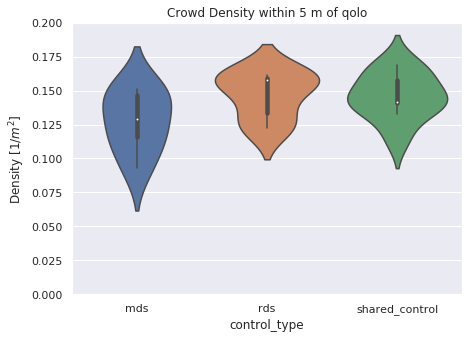

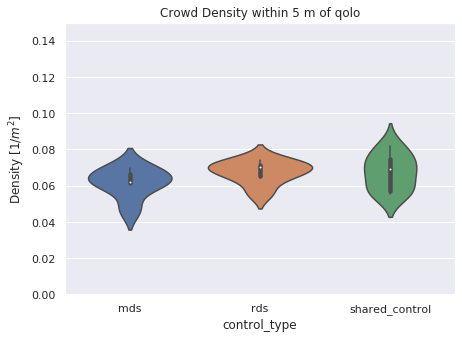

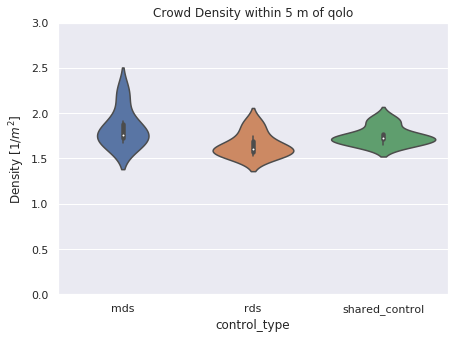

In [14]:
fig, axes = plt.subplots(figsize=(7,5))

boxplot(axes = axes,
        df = crowd_metrics_df_, 
        metric = 'avg_crowd_density5', 
        catogory = 'control_type', 
        title = 'Crowd Density within 5 m of qolo', 
        ylabel = 'Density [1/$m^2$]', 
        ylim = [0.0, 0.2])


fig2, axes2 = plt.subplots(figsize=(7,5))

boxplot(axes = axes2,
        df = crowd_metrics_df_, 
        metric = 'avg_crowd_density10', 
        catogory = 'control_type', 
        title = 'Crowd Density within 10 m of qolo', 
        ylabel = 'Density [1/$m^2$]', 
        ylim = [0.0, 0.15])

fig3, axes3 = plt.subplots(figsize=(7,5))

boxplot(axes = axes3,
        df = crowd_metrics_df_, 
        metric = 'avg_min_dist', 
        catogory = 'control_type', 
        title = 'Min. Distance of Pedestrain from qolo', 
        ylabel = 'Distance [m]', 
        ylim = [0.0, 3.0])

### Path Efficiency-related metrics

### Shared control-related metrics

## Archive 

In [4]:
main_dir = os.path.join(os.path.dirname(sys.path[0]), os.pardir)
# print(main_dir)

data_dir = os.path.join(main_dir,'data-crowdbot/')
control_type = ['rds/', 'shared_control/','mds/']
data_type = ['metrics/', 'pose_stamped', 'source_data']

# Testing directories:
fullPath = data_dir+control_type[2]+data_type[0]
print(fullPath)

mds_files = fnmatch.filter(os.listdir(path=fullPath), "*.npy")

print(mds_files)

/home/crowdbot/Documents/yujie/lasa_crowdbot_tools/../data-crowdbot/mds/metrics/


FileNotFoundError: [Errno 2] No such file or directory: '/home/crowdbot/Documents/yujie/lasa_crowdbot_tools/../data-crowdbot/mds/metrics/'

In [30]:
mds_tests = list()
rds_tests = list()
sh_tests = list()

rds_path = data_dir+control_type[0]+data_type[0]
rds_files = fnmatch.filter(os.listdir(path=rds_path), "*.npy")

shared_control_path = data_dir+control_type[1]+data_type[0]
shared_control_files = fnmatch.filter(os.listdir(path=shared_control_path), "*.npy")

mds_path = data_dir+control_type[2]+data_type[0]
mds_files = fnmatch.filter(os.listdir(path=mds_path), "*.npy")

print(rds_files[0])
rds_test = dict()
rds_test = np.load(rds_path+rds_files[0], allow_pickle=True).item()
rds_test['crowd_density10']

# TODO-1: Read the qolo_eval files and extract controller metrics

# print(rds_test['path_lenth2goal'])

2021-04-24-11-20-18_crowd_eval.npy
[0.10185917 0.11459156 0.11777466 ... 0.07321128 0.07957747 0.07957747]


### Crowd 
1. Crowd Density (within an area of 10m around the robot):
evalMetricCrowdDensity(npy_files_directory, plot_result=False)
2. Minimal distance to pedestrians: mean+SD: 
evalMetricProximity(npy_files_directory, plot_result=False):

2. Normalized proximity to surrounding pedestrians : SD(d1..dn) / avg(d1...dn)



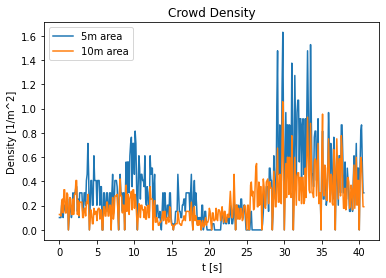

In [ ]:
plot_results = True
flag_tracker = False

test_dir = rds_tests[0]
density_detect = evalMetricCrowdDensity(test_dir,False,plot_results)

# density_track = evalMetricCrowdDensity(test_dir,True,plot_results)

min_dist = evalMetricProximity(test_dir, plot_results)

### Path Efficiency 
1. Relative time to goal (normalized by the goal distance)
2. Relative path length (normalized by the goal distance in straight line): 
evalMetricsPathAndTimeToGoal(npy_files_directory, plot_result=False):

3. Relative Jerk (smoothness of the path as added sum of linear and angular jerk): 


In [ ]:
plot_results = True
# path_length_to_goal, time_duration_to_goal, min_dist (to the Attractor)
evalMetricsPathAndTimeToGoal(test_dir, plot_results)

### Shared Control 
1. Agreement
2. Fluency
3. Entropy

shared_control(npy_files_directory, plot_result=False)

In [ ]:
# metrics['fluency']['mean'] = 

fluency, linear_dis, heading_dis, disagreement = MetricsSharedControl(test_dir, plot_results)
print(linear_dis)
print(heading_dis)